## Import

In [1]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

2.0.0+cu118 True


In [2]:
import pandas as pd
import numpy as np
from PIL import Image

import os
import shutil
import random

import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

## Image Generate

#### image

In [3]:
import os
import shutil

# 원본 폴더 경로
origin_folder = "./1.Training/origin_image/train_buildings_images/"

# 대상 폴더 경로
target_folder = "./train/image/"

# 대상 폴더가 없다면 생성
if not os.path.exists(target_folder):
    os.makedirs(target_folder)

# 원본 폴더에서 .png 파일 찾아서 대상 폴더로 복사
for filename in tqdm(os.listdir(origin_folder)):
    if filename.endswith(".png"):
        origin_filepath = os.path.join(origin_folder, filename)
        target_filepath = os.path.join(target_folder, filename)
        shutil.copyfile(origin_filepath, target_filepath)

100%|██████████| 3714/3714 [00:10<00:00, 346.96it/s]


In [4]:
import os
import shutil

# 원본 폴더 경로
origin_folder = "./2.Validation/origin_image/validate_buildings_images/"

# 대상 폴더 경로
target_folder = "./valid/image/"

# 대상 폴더가 없다면 생성
if not os.path.exists(target_folder):
    os.makedirs(target_folder)

# 원본 폴더에서 .png 파일 찾아서 대상 폴더로 복사
for filename in tqdm(os.listdir(origin_folder)):
    if filename.endswith(".png"):
        origin_filepath = os.path.join(origin_folder, filename)
        target_filepath = os.path.join(target_folder, filename)
        shutil.copyfile(origin_filepath, target_filepath)

100%|██████████| 477/477 [00:01<00:00, 352.68it/s]


#### Masking Image

In [3]:
import os
import json
from PIL import Image, ImageDraw
from tqdm import tqdm

# Input and output directories
json_directory = "./1.Training/origin_label/train_buildings_labels/"
output_directory = "./train/mask/"

# Ensure the output directory exists
os.makedirs(output_directory, exist_ok=True)

# Process each JSON file in the input directory
for json_file in tqdm(os.listdir(json_directory)):
    if json_file.endswith(".json"):
        with open(os.path.join(json_directory, json_file)) as f:
            data = json.load(f)

        # Use the JSON file name (without extension) as image_id
        image_id = os.path.splitext(json_file)[0]

        # Create a blank mask image
        mask_image = Image.new("L", (1024, 1024), 0)
        draw = ImageDraw.Draw(mask_image)

        # Iterate over features and draw polygons on the mask image
        for feature in data['features']:
            building_coords = feature['properties']['building_imcoords']
            if building_coords != 'EMPTY':
                building_coords = list(map(float, building_coords.split(', ')))
                building_coords = [(building_coords[i], building_coords[i + 1]) for i in range(0, len(building_coords), 2)]
                draw.polygon(building_coords, outline=1, fill=1)

        # Save the mask image with the JSON file name
        mask_image.save(os.path.join(output_directory, f"{image_id}_mask.png"))


  0%|          | 0/1238 [00:00<?, ?it/s]

100%|██████████| 1238/1238 [00:21<00:00, 57.50it/s]


In [4]:
import os
import json
from PIL import Image, ImageDraw
from tqdm import tqdm

# Input and output directories
json_directory = "./2.Validation/origin_label/validate_buildings_labels/"
output_directory = "./valid/mask/"

# Ensure the output directory exists
os.makedirs(output_directory, exist_ok=True)

# Process each JSON file in the input directory
for json_file in tqdm(os.listdir(json_directory)):
    if json_file.endswith(".json"):
        with open(os.path.join(json_directory, json_file)) as f:
            data = json.load(f)

        # Use the JSON file name (without extension) as image_id
        image_id = os.path.splitext(json_file)[0]

        # Create a blank mask image
        mask_image = Image.new("L", (1024, 1024), 0)
        draw = ImageDraw.Draw(mask_image)

        # Iterate over features and draw polygons on the mask image
        for feature in data['features']:
            building_coords = feature['properties']['building_imcoords']
            if building_coords != 'EMPTY':
                building_coords = list(map(float, building_coords.split(', ')))
                building_coords = [(building_coords[i], building_coords[i + 1]) for i in range(0, len(building_coords), 2)]
                draw.polygon(building_coords, outline=1, fill=1)

        # Save the mask image with the JSON file name
        mask_image.save(os.path.join(output_directory, f"{image_id}_mask.png"))


100%|██████████| 159/159 [00:03<00:00, 50.45it/s]


#### Image Crop

In [4]:
from PIL import Image
import os

def split_and_save_images(original_path, mask_path, save_path_image, save_path_mask):
    # 원본 이미지와 마스크 이미지 목록 가져오기
    original_images = os.listdir(original_path)
    mask_images = os.listdir(mask_path)

    # 512x512로 이미지를 나누고 저장
    for original_image_name in tqdm(original_images):
        if original_image_name.endswith('.png'):
            original_image_path = os.path.join(original_path, original_image_name)
            mask_image_name = original_image_name.replace('.png', '_mask.png')
            mask_image_path = os.path.join(mask_path, mask_image_name)

            original_img = Image.open(original_image_path)
            mask_img = Image.open(mask_image_path)

            # 이미지를 4등분
            for i in range(2):
                for j in range(2):
                    left = i * 512
                    upper = j * 512
                    right = left + 512
                    lower = upper + 512

                    # 원본 이미지 저장
                    save_name = f"{original_image_name.split('.')[0]}_{i * 2 + j + 1}.png"
                    save_path_img = os.path.join(save_path_image, save_name)
                    cropped_original = original_img.crop((left, upper, right, lower))
                    cropped_original.save(save_path_img)

                    # 마스크 이미지 저장
                    save_name_mask = f"{original_image_name.split('.')[0]}_{i * 2 + j + 1}_mask.png"
                    save_path_mask_img = os.path.join(save_path_mask, save_name_mask)
                    cropped_mask = mask_img.crop((left, upper, right, lower))
                    cropped_mask.save(save_path_mask_img)

if __name__ == "__main__":
    original_path = "./train/image/"
    mask_path = "./train/mask/"
    save_path_image = "./Segmentation_data/train/image[0~100]/"
    save_path_mask = "./Segmentation_data/train/mask[0~100]/"

    # 저장할 디렉토리가 없으면 생성
    os.makedirs(save_path_image, exist_ok=True)
    os.makedirs(save_path_mask, exist_ok=True)

    split_and_save_images(original_path, mask_path, save_path_image, save_path_mask)


  0%|          | 0/1238 [00:00<?, ?it/s]

100%|██████████| 1238/1238 [10:04<00:00,  2.05it/s]


In [5]:
from PIL import Image
import os

def split_and_save_images(original_path, mask_path, save_path_image, save_path_mask):
    # 원본 이미지와 마스크 이미지 목록 가져오기
    original_images = os.listdir(original_path)
    mask_images = os.listdir(mask_path)

    # 512x512로 이미지를 나누고 저장
    for original_image_name in tqdm(original_images):
        if original_image_name.endswith('.png'):
            original_image_path = os.path.join(original_path, original_image_name)
            mask_image_name = original_image_name.replace('.png', '_mask.png')
            mask_image_path = os.path.join(mask_path, mask_image_name)

            original_img = Image.open(original_image_path)
            mask_img = Image.open(mask_image_path)

            # 이미지를 4등분
            for i in range(2):
                for j in range(2):
                    left = i * 512
                    upper = j * 512
                    right = left + 512
                    lower = upper + 512

                    # 원본 이미지 저장
                    save_name = f"{original_image_name.split('.')[0]}_{i * 2 + j + 1}.png"
                    save_path_img = os.path.join(save_path_image, save_name)
                    cropped_original = original_img.crop((left, upper, right, lower))
                    cropped_original.save(save_path_img)

                    # 마스크 이미지 저장
                    save_name_mask = f"{original_image_name.split('.')[0]}_{i * 2 + j + 1}_mask.png"
                    save_path_mask_img = os.path.join(save_path_mask, save_name_mask)
                    cropped_mask = mask_img.crop((left, upper, right, lower))
                    cropped_mask.save(save_path_mask_img)

if __name__ == "__main__":
    original_path = "./valid/image/"
    mask_path = "./valid/mask/"
    save_path_image = "./Segmentation_data/valid/image/"
    save_path_mask = "./Segmentation_data/valid/mask/"

    # 저장할 디렉토리가 없으면 생성
    os.makedirs(save_path_image, exist_ok=True)
    os.makedirs(save_path_mask, exist_ok=True)

    split_and_save_images(original_path, mask_path, save_path_image, save_path_mask)


100%|██████████| 159/159 [01:15<00:00,  2.12it/s]


## Building 면적 확인

In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 마스킹 이미지가 있는 디렉토리 경로
mask_dir = "./Segmentation_data/train/mask[0~100]/"

# 디렉토리 내의 모든 파일 가져오기
mask_files = os.listdir(mask_dir)

# 객체 크기를 저장할 리스트
object_sizes = []

# 모든 마스크 이미지에 대해 반복
for mask_file in tqdm(mask_files):
    # 이미지 읽기
    mask_path = os.path.join(mask_dir, mask_file)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # 객체 감지 (흰색 영역)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 객체 크기 측정 및 저장
    for contour in contours:
        object_size = cv2.contourArea(contour)
        object_sizes.append(object_size)

  0%|          | 0/4952 [00:00<?, ?it/s]

100%|██████████| 4952/4952 [00:29<00:00, 169.73it/s]


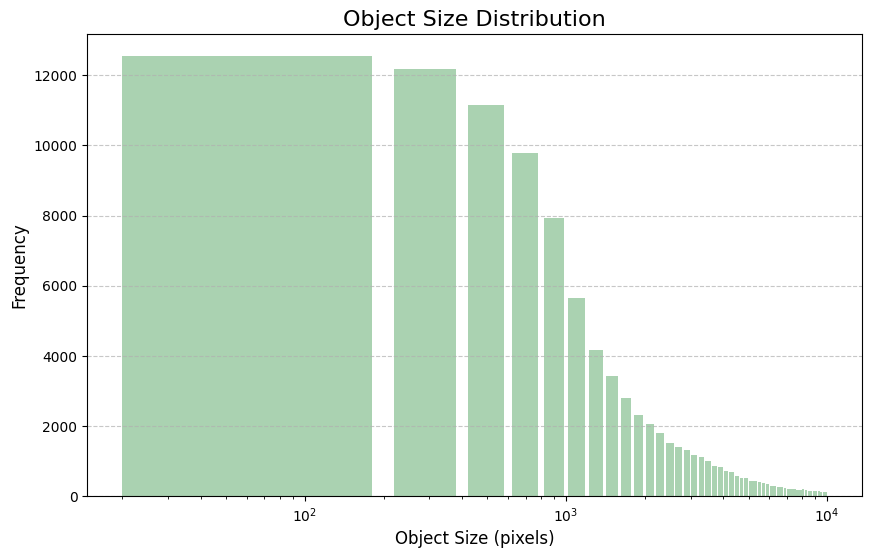

In [7]:
plt.figure(figsize=(10, 6))
plt.hist(object_sizes, bins=50, range=(0, 10000), color='#86bf91', rwidth=0.8, alpha=0.7)
plt.xscale('log')  # Logarithmic scale on the x-axis for better representation
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Object Size Distribution', fontsize=16)
plt.xlabel('Object Size (pixels)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

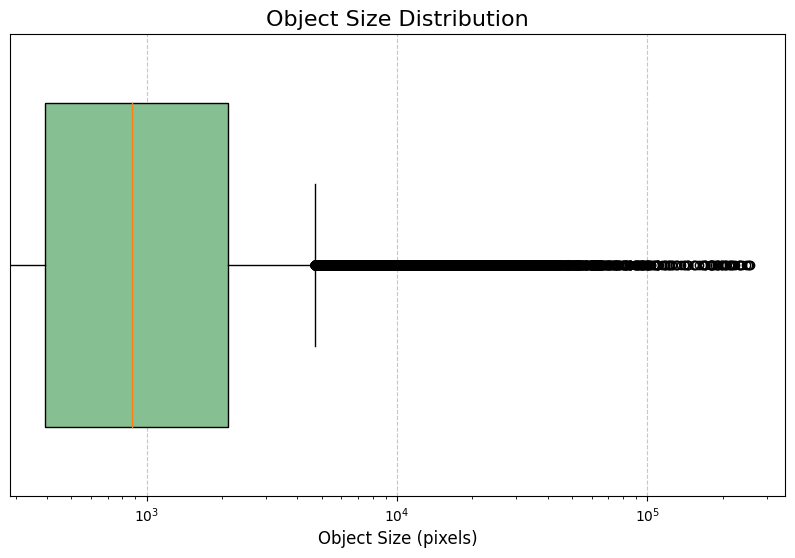

In [8]:
plt.figure(figsize=(10, 6))
plt.boxplot(object_sizes, vert=False, widths=0.7, patch_artist=True, boxprops=dict(facecolor='#86bf91', color='black'))
plt.xscale('log')  # Logarithmic scale on the x-axis for better representation
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.title('Object Size Distribution', fontsize=16)
plt.xlabel('Object Size (pixels)', fontsize=12)
plt.yticks([])
plt.xticks(fontsize=10)
plt.show()

## Building area ratio of masking image

In [9]:
# 경로 설정
folder_path = "./Segmentation_data/train/mask[0~100]/"

# 폴더 내의 모든 파일 가져오기
mask_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# 결과를 저장할 리스트 초기화
data = []

# 각 mask 이미지 처리
for mask_file in tqdm(mask_files, desc="Processing", unit="image"):
    mask_image_path = os.path.join(folder_path, mask_file)
    
    # Mask 이미지를 NumPy 배열로 불러오기
    mask_image = np.array(Image.open(mask_image_path))
    
    # 전체 픽셀 수
    total_pixels = mask_image.size
    
    # Object(마스크)인 픽셀 수 계산
    object_pixels = np.count_nonzero(mask_image)  # nonzero 픽셀이 Object(마스크) 부분
    
    # 배경인 픽셀 수 계산
    background_pixels = total_pixels - object_pixels
    
    # Object Ratio 계산
    object_ratio = object_pixels / total_pixels
    
    # Background Ratio 계산
    background_ratio = background_pixels / total_pixels
    
    # 결과 데이터에 추가
    data.append({
        "Mask Image": mask_file,
        "Object Ratio": object_ratio * 100,
        "Background Ratio": background_ratio * 100
    })

# 데이터를 pandas DataFrame으로 변환
building_ratio = pd.DataFrame(data)
building_ratio

Processing: 100%|██████████| 4952/4952 [00:05<00:00, 973.00image/s] 


,Mask Image,Object Ratio,Background Ratio
0,BLD00001_PS3_K3A_NIA0276_1_mask.png,28.547668,71.452332
1,BLD00001_PS3_K3A_NIA0276_2_mask.png,45.045471,54.954529
2,BLD00001_PS3_K3A_NIA0276_3_mask.png,34.791183,65.208817
3,BLD00001_PS3_K3A_NIA0276_4_mask.png,36.003494,63.996506
4,BLD00002_PS3_K3A_NIA0276_1_mask.png,33.979416,66.020584
...,...,...,...
4947,OBJ04022_PS3_K3A_NIA0169_4_mask.png,16.505432,83.494568
4948,OBJ04023_PS3_K3A_NIA0169_1_mask.png,1.640320,98.359680
4949,OBJ04023_PS3_K3A_NIA0169_2_mask.png,1.097870,98.902130
4950,OBJ04023_PS3_K3A_NIA0169_3_mask.png,0.084686,99.915314


Mean Object Ratio: 18.16
Standard Deviation Object Ratio: 18.28


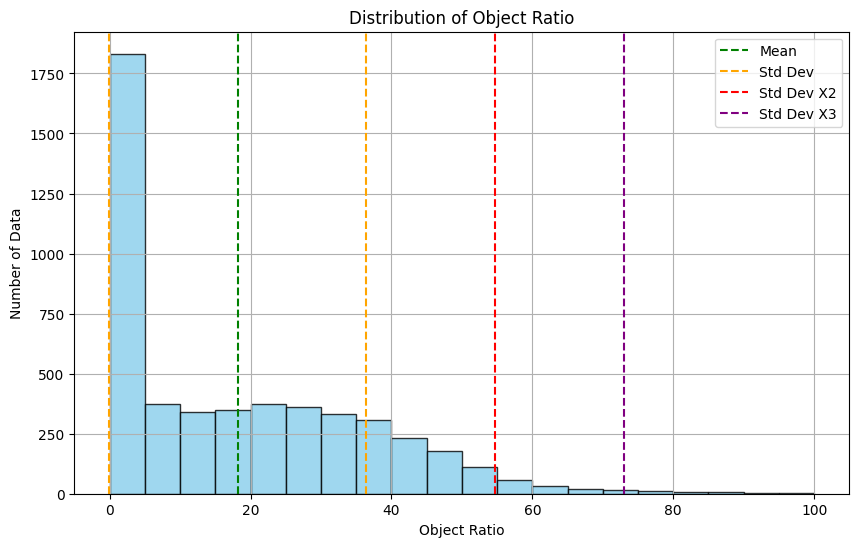

In [36]:
x_ticks = np.arange(0, 101, 5)  # 0부터 100까지 5% 단위로

# Object Ratio의 평균 및 표준편차 계산
Object_ratio_mean = building_ratio["Object Ratio"].mean()
Object_ratio_std = building_ratio["Object Ratio"].std()

# 시각화
plt.figure(figsize=(10, 6))
plt.hist(building_ratio["Object Ratio"], bins=x_ticks, edgecolor='black', alpha=0.8, color='skyblue')
plt.axvline(Object_ratio_mean, color='green', linestyle='dashed', linewidth=1.5, label='Mean')
plt.axvline(Object_ratio_mean - Object_ratio_std, color='orange', linestyle='dashed', linewidth=1.5)
plt.axvline(Object_ratio_mean + Object_ratio_std, color='orange', linestyle='dashed', linewidth=1.5, label='Std Dev')
plt.axvline(Object_ratio_mean + Object_ratio_std*2, color='red', linestyle='dashed', linewidth=1.5, label='Std Dev X2')
plt.axvline(Object_ratio_mean + Object_ratio_std*3, color='purple', linestyle='dashed', linewidth=1.5, label='Std Dev X3')
plt.xlabel('Object Ratio')
plt.ylabel('Number of Data')
plt.title('Distribution of Object Ratio')
plt.legend()

# 평균 및 표준편차 출력
print(f"Mean Object Ratio: {Object_ratio_mean:.2f}")
print(f"Standard Deviation Object Ratio: {Object_ratio_std:.2f}")

plt.grid(True)
plt.show()


In [37]:
Object_ratio_mean + Object_ratio_std*3

73.00029014960268

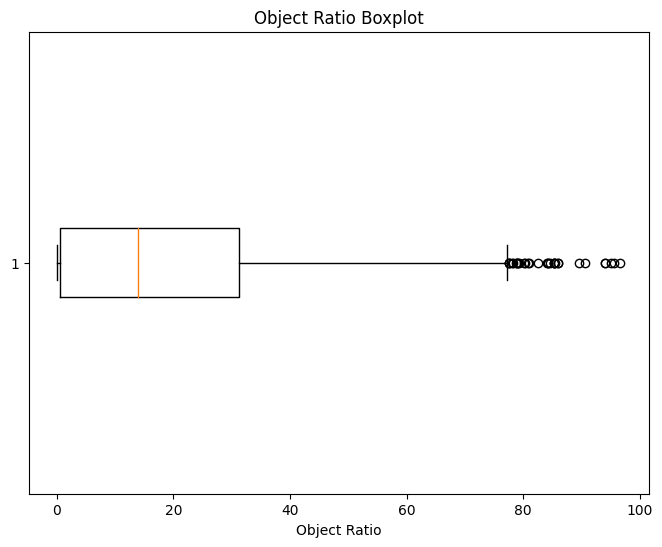

Q1: 0.5650
Q3: 31.2703
IQR: 30.7054
Lower Bound: -45.4931
Upper Bound: 77.3283


In [28]:
# 박스플롯 그리기
plt.figure(figsize=(8, 6))
plt.boxplot(building_ratio['Object Ratio'], vert=False)
plt.title('Object Ratio Boxplot')
plt.xlabel('Object Ratio')
plt.show()

# 분위수 계산
q1 = building_ratio['Object Ratio'].quantile(0.25)
q3 = building_ratio['Object Ratio'].quantile(0.75)
iqr = q3 - q1

# 이상치 확인
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = building_ratio[(building_ratio['Object Ratio'] < lower_bound) | (building_ratio['Object Ratio'] > upper_bound)]

print(f'Q1: {q1:.4f}')
print(f'Q3: {q3:.4f}')
print(f'IQR: {iqr:.4f}')
print(f'Lower Bound: {lower_bound:.4f}')
print(f'Upper Bound: {upper_bound:.4f}')

## Image file shutiling Building area ratio of masking image

In [50]:
import shutil

# 임계값 리스트 설정
thresholds = [Object_ratio_mean + Object_ratio_std,
              Object_ratio_mean + Object_ratio_std*2,
              Object_ratio_mean + Object_ratio_std*3]

for thres in tqdm(thresholds):
    # 조건에 해당하는 행 선택
    selected_rows = building_ratio[building_ratio['Object Ratio'] <= thres]

    # 복사할 디렉터리 경로 생성
    new_image_dir = f"./Segmentation_data/train/image[0~{thres:.2f}]/"
    new_mask_dir = f"./Segmentation_data/train/mask[0~{thres:.2f}]/"

    os.makedirs(new_mask_dir, exist_ok=True)
    os.makedirs(new_image_dir, exist_ok=True)

    for index, row in tqdm(selected_rows.iterrows()):
        mask_filename = row['Mask Image']  # 예: image_name_mask.png
        image_filename = mask_filename.replace("_mask.png", ".png")  # 예: image_name.png

        # 관련 이미지 복사
        original_image_path = f"./Segmentation_data/train/image[0~100]/{image_filename}"
        new_image_path = os.path.join(new_image_dir, image_filename)
        shutil.copy(original_image_path, new_image_path)
        
        # 마스크 이미지 복사
        original_mask_path = f"./Segmentation_data/train/mask[0~100]/{mask_filename}"
        new_mask_path = os.path.join(new_mask_dir, mask_filename)
        shutil.copy(original_mask_path, new_mask_path)

print("복사가 완료되었습니다.")

4055it [00:16, 249.17it/s]0<?, ?it/s]
4789it [00:19, 242.79it/s]6<00:32, 16.28s/it]
4912it [00:20, 243.51it/s]6<00:18, 18.31s/it]
100%|██████████| 3/3 [00:56<00:00, 18.73s/it]

복사가 완료되었습니다.


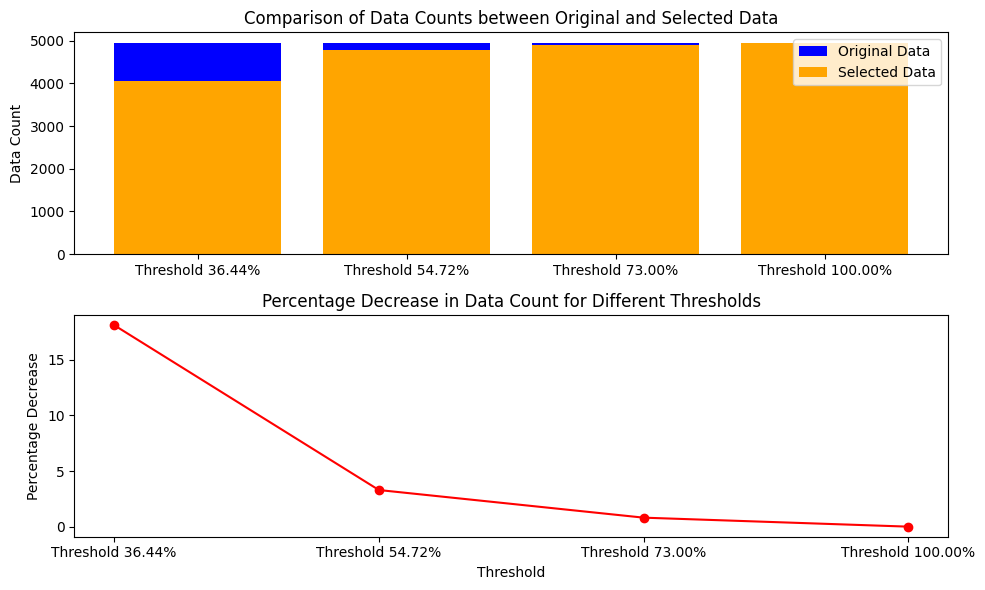

For threshold 36.442058595576285%, selected data has decreased by 18.11% compared to the original data.
For threshold 54.72117437258947%, selected data has decreased by 3.29% compared to the original data.
For threshold 73.00029014960268%, selected data has decreased by 0.81% compared to the original data.
For threshold 100%, selected data has decreased by 0.00% compared to the original data.


In [56]:
import os
import matplotlib.pyplot as plt

# List of threshold values
thresholds = [Object_ratio_mean + Object_ratio_std,
              Object_ratio_mean + Object_ratio_std*2,
              Object_ratio_mean + Object_ratio_std*3,
              100]

# Folder paths
folder1 = f'./Segmentation_data/train/image[0~100]/'  # Original data folder

# Visualization data
data_counts_original = []
data_counts_selected = []
percentage_decreases = []

# Calculate data counts and percentage decreases for each threshold
for thres in thresholds:
    if thres == 100:
        folder2 = f'./Segmentation_data/train/image[0~{thres}]/'  # Selected data folder
    else:
        folder2 = f'./Segmentation_data/train/image[0~{thres:.2f}]/'
        
    count1 = len(os.listdir(folder1))
    count2 = len(os.listdir(folder2))
    
    data_counts_original.append(count1)
    data_counts_selected.append(count2)
    
    percentage_decrease = ((count1 - count2) / count1) * 100
    percentage_decreases.append(percentage_decrease)

# Visualization
labels = [f"Threshold {thres:.2f}%" for thres in thresholds]

plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.bar(labels, data_counts_original, color='blue', label='Original Data')
plt.bar(labels, data_counts_selected, color='orange', label='Selected Data')
plt.ylabel('Data Count')
plt.title('Comparison of Data Counts between Original and Selected Data')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(labels, percentage_decreases, marker='o', color='red')
plt.xlabel('Threshold')
plt.ylabel('Percentage Decrease')
plt.title('Percentage Decrease in Data Count for Different Thresholds')

plt.tight_layout()
plt.show()

for i, thres in enumerate(thresholds):
    print(f"For threshold {thres}%, selected data has decreased by {percentage_decreases[i]:.2f}% compared to the original data.")


In [54]:
import shutil

# 임계값 리스트 설정
thresholds = [Object_ratio_mean + Object_ratio_std,
              Object_ratio_mean + Object_ratio_std*2,
              Object_ratio_mean + Object_ratio_std*3,
              100]

for thres in tqdm(thresholds):       
    # 조건에 해당하는 행 선택
    selected_rows = building_ratio[(building_ratio['Object Ratio'] <= thres) & (building_ratio['Object Ratio'] > 0)]

    # 복사할 디렉터리 경로 생성
    if thres == 100:
        new_image_dir = f"./Segmentation_data/train/image(0~{thres}]/"
        new_mask_dir = f"./Segmentation_data/train/mask(0~{thres}]/"
    else:
        new_image_dir = f"./Segmentation_data/train/image(0~{thres:.2f}]/"
        new_mask_dir = f"./Segmentation_data/train/mask(0~{thres:.2f}]/"

    os.makedirs(new_mask_dir, exist_ok=True)
    os.makedirs(new_image_dir, exist_ok=True)

    for index, row in tqdm(selected_rows.iterrows()):
        mask_filename = row['Mask Image']  # 예: image_name_mask.png
        image_filename = mask_filename.replace("_mask.png", ".png")  # 예: image_name.png

        # 관련 이미지 복사
        original_image_path = f"./Segmentation_data/train/image[0~100]/{image_filename}"
        new_image_path = os.path.join(new_image_dir, image_filename)
        shutil.copy(original_image_path, new_image_path)
        
        # 마스크 이미지 복사
        original_mask_path = f"./Segmentation_data/train/mask[0~100]/{mask_filename}"
        new_mask_path = os.path.join(new_mask_dir, mask_filename)
        shutil.copy(original_mask_path, new_mask_path)

print("복사가 완료되었습니다.")

3196it [00:13, 245.24it/s]0<?, ?it/s]
3930it [00:16, 236.82it/s]3<00:39, 13.04s/it]
4053it [00:17, 235.37it/s]9<00:30, 15.13s/it]
4093it [00:17, 240.00it/s]6<00:16, 16.09s/it]
100%|██████████| 4/4 [01:03<00:00, 15.98s/it]

복사가 완료되었습니다.


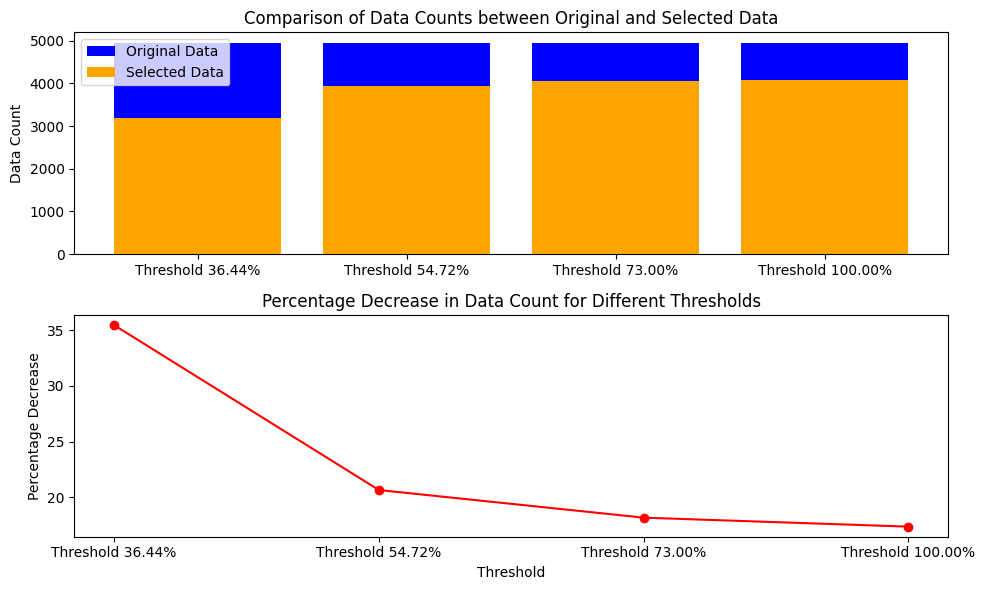

For threshold 36.442058595576285%, selected data has decreased by 35.46% compared to the original data.
For threshold 54.72117437258947%, selected data has decreased by 20.64% compared to the original data.
For threshold 73.00029014960268%, selected data has decreased by 18.15% compared to the original data.
For threshold 100%, selected data has decreased by 17.35% compared to the original data.


In [57]:
import os
import matplotlib.pyplot as plt

# List of threshold values
thresholds = [Object_ratio_mean + Object_ratio_std,
              Object_ratio_mean + Object_ratio_std*2,
              Object_ratio_mean + Object_ratio_std*3,
              100]

# Folder paths
folder1 = f'./Segmentation_data/train/image[0~100]/'  # Original data folder

# Visualization data
data_counts_original = []
data_counts_selected = []
percentage_decreases = []

# Calculate data counts and percentage decreases for each threshold
for thres in thresholds:
    if thres == 100:
        folder2 = f'./Segmentation_data/train/image(0~{thres}]/'  # Selected data folder
    else:
        folder2 = f'./Segmentation_data/train/image(0~{thres:.2f}]/'
        
    count1 = len(os.listdir(folder1))
    count2 = len(os.listdir(folder2))
    
    data_counts_original.append(count1)
    data_counts_selected.append(count2)
    
    percentage_decrease = ((count1 - count2) / count1) * 100
    percentage_decreases.append(percentage_decrease)

# Visualization
labels = [f"Threshold {thres:.2f}%" for thres in thresholds]

plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.bar(labels, data_counts_original, color='blue', label='Original Data')
plt.bar(labels, data_counts_selected, color='orange', label='Selected Data')
plt.ylabel('Data Count')
plt.title('Comparison of Data Counts between Original and Selected Data')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(labels, percentage_decreases, marker='o', color='red')
plt.xlabel('Threshold')
plt.ylabel('Percentage Decrease')
plt.title('Percentage Decrease in Data Count for Different Thresholds')

plt.tight_layout()
plt.show()

for i, thres in enumerate(thresholds):
    print(f"For threshold {thres}%, selected data has decreased by {percentage_decreases[i]:.2f}% compared to the original data.")
